## Project 5 : Vehicle Detection
In this project, our goals / steps are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier (I used Linear SVM classifier in this project)
* Apply a color transform and binned color features, as well as histograms of color, to the HOG feature vector.(Note: for those first two steps we need to first normalize the features and, splitting the data into training and testing data and also randomize a selection for training and testing.)
* Implement a sliding-window technique and use the previously trained classifier to search for vehicles in images.
* Estimate a bounding box for vehicles detected.
* Run your pipeline on a video stream. 

### Importing all relevant libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
# My scikit-learn version is > 0.18, therefore I use:
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

print('Libraries imported...')

Libraries imported...


### Loading the images (car and notcar images)

In [2]:
## Read in cars and notcars
# Read notcars 
images = glob.glob('non-vehicles/Extras/*.png')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Read in cars and notcars
images = glob.glob('non-vehicles/GTI/*.png')
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Read in cars
images = glob.glob('vehicles/KITTI_extracted/*.png')
for image in images:
    if 'car' in image:
        cars.append(image)
    else:
        notcars.append(image)

images = glob.glob('vehicles/GTI_Far/*.png')
for image in images:
    if 'farimage' in image:
        cars.append(image)
    else:
        notcars.append(image)

images = glob.glob('vehicles/GTI_Left/*.png')
for image in images:
    if 'Leftimage' in image:
        cars.append(image)
    else:
        notcars.append(image)

images = glob.glob('vehicles/GTI_Right/*.png')
for image in images:
    if 'Rightimage' in image:
        cars.append(image)
    else:
        notcars.append(image)

images = glob.glob('vehicles/GTI_MiddleClose/*.png')
for image in images:
    if 'mcloseimage' in image:
        cars.append(image)
    else:
        notcars.append(image)

print('Total Car images', len(cars))
print('Total Non-Car images', len(notcars))

Total Car images 8792
Total Non-Car images 8968


### Visualize the data

In [ ]:
# fig, axs = plt.subplots(6,6, figsize=(16, 16))
# fig.subplots_adjust(hspace = .2, wspace=.001)
# axs = axs.ravel()

# # Step through the list and search for chessboard corners
# for i in np.arange(18):
#     img = cv2.imread(cars[np.random.randint(0,len(cars))])
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     axs[i].axis('off')
#     axs[i].set_title('car', fontsize=10)
#     axs[i].imshow(img)
# for i in np.arange(18,36):
#     img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     axs[i].axis('off')
#     axs[i].set_title('Not car', fontsize=10)
#     axs[i].imshow(img)

### Extract HOG features of an image

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Apply the HOG Feature to the list of car and non-car images read above

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
#def color_hist(img, nbins=32, bins_range=(0, 256)): use when reading .jpg files
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to convert the color space/domain of an image
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist() - defined below
def extract_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)    
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### Do the following
* Extract Features for Input Datasets and Combine, 
* Define Labels Vector, 
* Shuffle and Split

In [5]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 32    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
y_start_stop = [400, 500] # Min and max in y to search in slide_window()

t_start = time.time() #start time

car_features = extract_features(cars, color_space=color_space,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=color_space,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t_stop = time.time() #stop time
print('It takes', round(t_stop-t_start, 2), 'seconds to extract HOG features.')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets 
# As frequently used in previous projects, I'm using 80/20 rule. 
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Size of Training Data',len(X_train))
print('Size of Validtion/Test Data',len(X_test))

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

It takes 35.41 seconds to extract HOG features.
Size of Training Data 14208
Size of Validtion/Test Data 3552
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


### Train the classfier 
Train the classfier using the Support Vector Machines (Linear SLinearSVC is used that is another implementation of Support Vector Classification for the case of a linear kernel.)

In [6]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t_start = time.time() #start time
svc.fit(X_train, y_train)
t_stop = time.time() #stop time
print('It takes', round(t_stop-t_start, 2), 'seconds to train the SVC.')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

It takes 1.28 seconds to train the SVC.
Test Accuracy of SVC =  0.9806


### Using the above Linear Support Vector Classifier (LinearSVC) to Detect Cars in an Image

In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # array of rectangles where cars were detected
    rectangles = []
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)
#             # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
 
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    return rectangles
    #return draw_img

img = mpimg.imread('test_images/test6.jpg')   
ystart =400
ystop =550
scale = 1.5
    
rectangles = find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

#plt.imshow(out_img)
print(len(rectangles), 'rectangles found in image')

6 rectangles found in image


### Draw Rectangles on the image

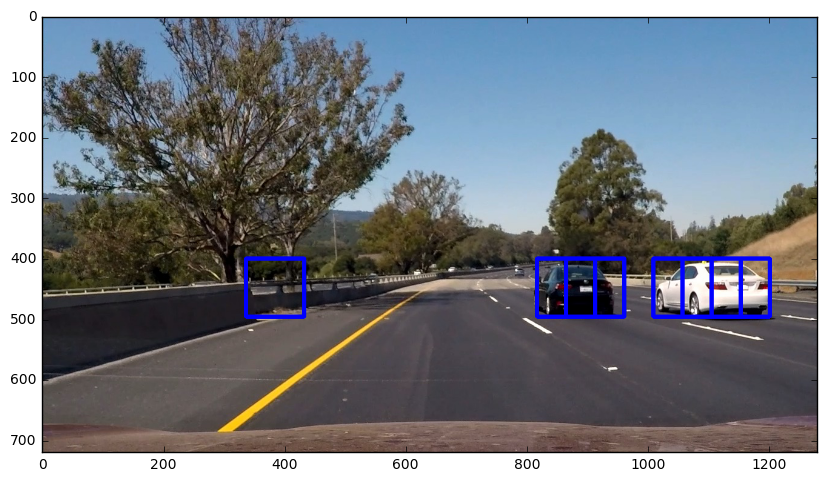

In [8]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

img_rects = draw_boxes(img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(img_rects)

As suggested in the lecture we need to swipe through the whole horizontal plane under the sky and treeline. Because we expect our cars to be located anywhere in this region. So, we need to scan the whole region. And since the size and shape of the car will be also not remain throught, we need to keep changing the window size to accurately track the car.

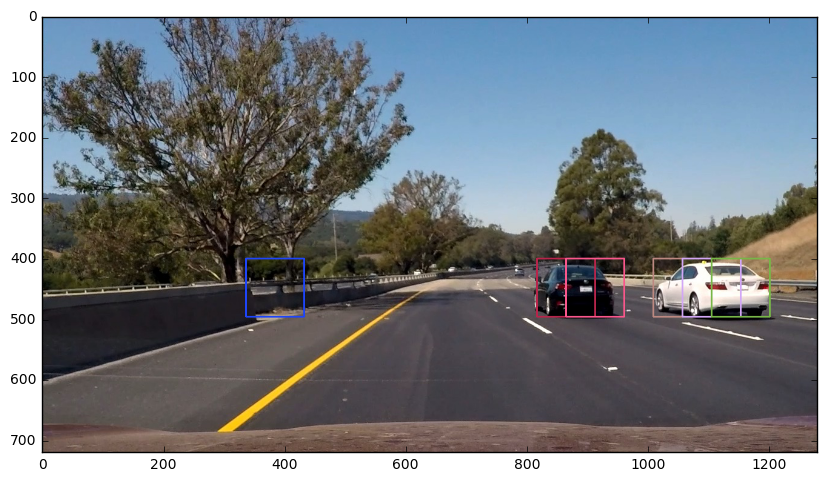

In [9]:
test_img = mpimg.imread('./test_images/test6.jpg')

rects = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

#Small Search Window
ystart = 370
ystop = 480
scale = 1.5
rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

ystart = 400
ystop = 550
scale = 1.5
rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

# #Medium seearch window
# ystart = 350
# ystop = 550
# scale = 2.0
# rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

# ystart = 400
# ystop = 600
# scale = 2.0
# rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

# #Big Search Window
# ystart = 350
# ystop = 600
# scale = 2.5
# rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

# ystart = 400
# ystop = 650
# scale = 2.5
# rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

# ystart = 450
# ystop = 700
# scale = 2.5
# rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rects = [item for sublist in rects for item in sublist] 

test_img_rects = draw_boxes(test_img, rects, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

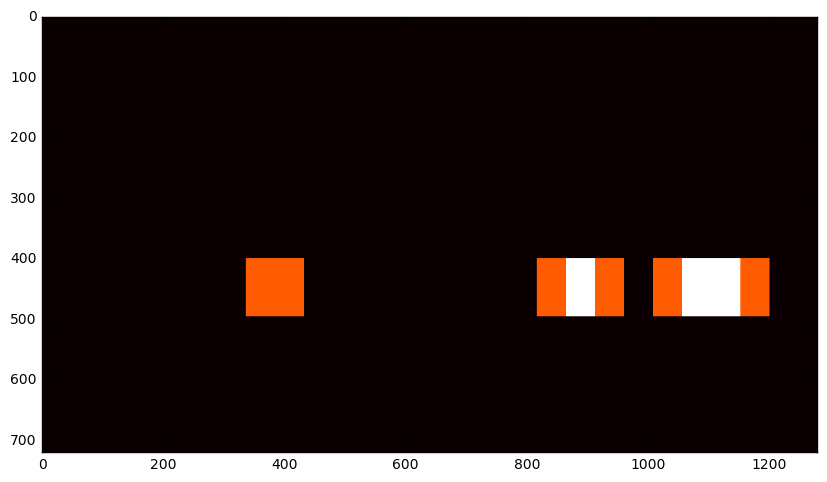

In [10]:
# Heatmap based on rectangle locations

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Test out the heatmap
heatmap_img = np.zeros_like(img[:,:,0])
heatmap_img = add_heat(heatmap_img, rects)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

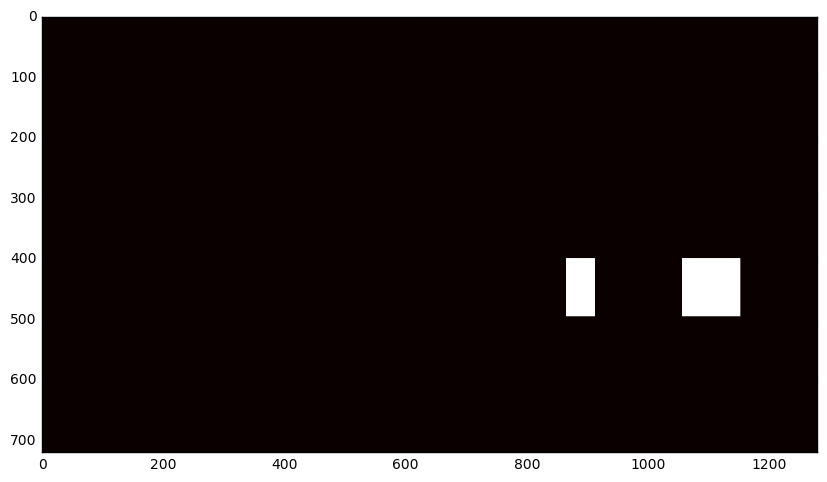

In [11]:
# Apply a Threshold to the Heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 car(s) found


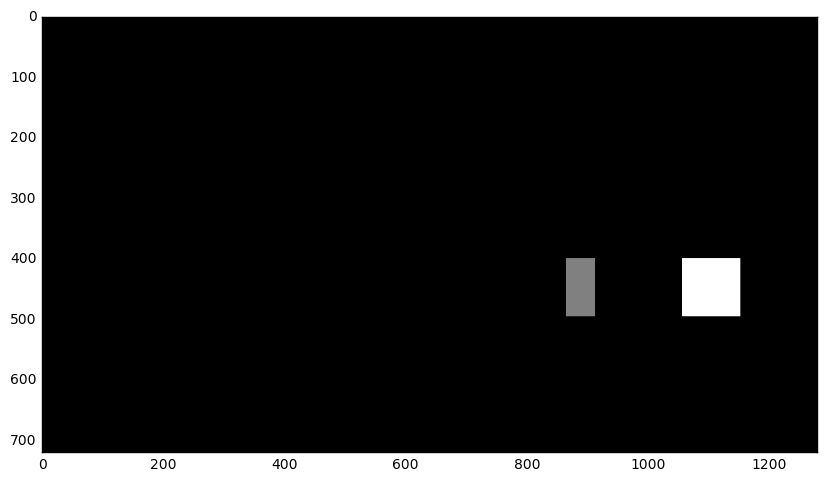

In [12]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'car(s) found')

### Draw bounding Boxes

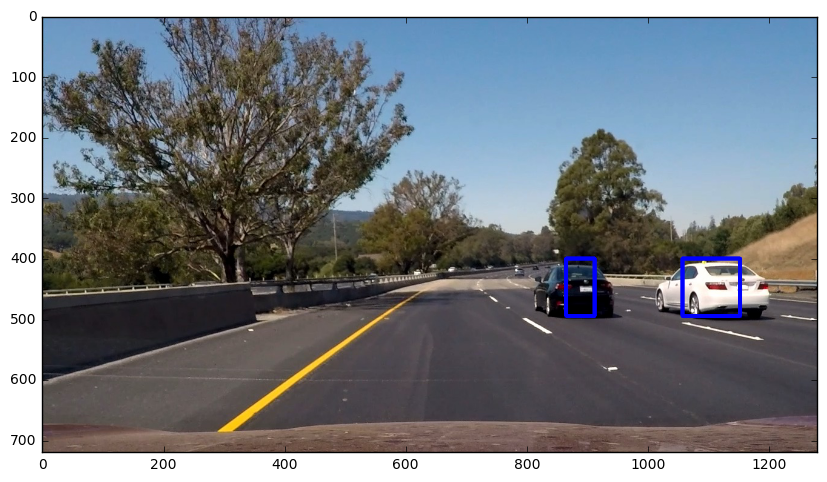

In [13]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [14]:
def process_frame(img):

    rects = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 370
    ystop = 480
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

    ystart = 400
    ystop = 550
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

#     ystart = 350
#     ystop = 550
#     scale = 2.0
#     rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

#     ystart = 400
#     ystop = 600
#     scale = 2.0
#     rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

#     ystart = 350
#     ystop = 600
#     scale = 2.5
#     rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

#     ystart = 400
#     ystop = 650
#     scale = 2.5
#     rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

#     ystart = 450
#     ystop = 700
#     scale = 2.5
#     rects.append(find_cars(img, ystart, ystop, scale, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
   
    rects = [item for sublist in rects for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rects)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

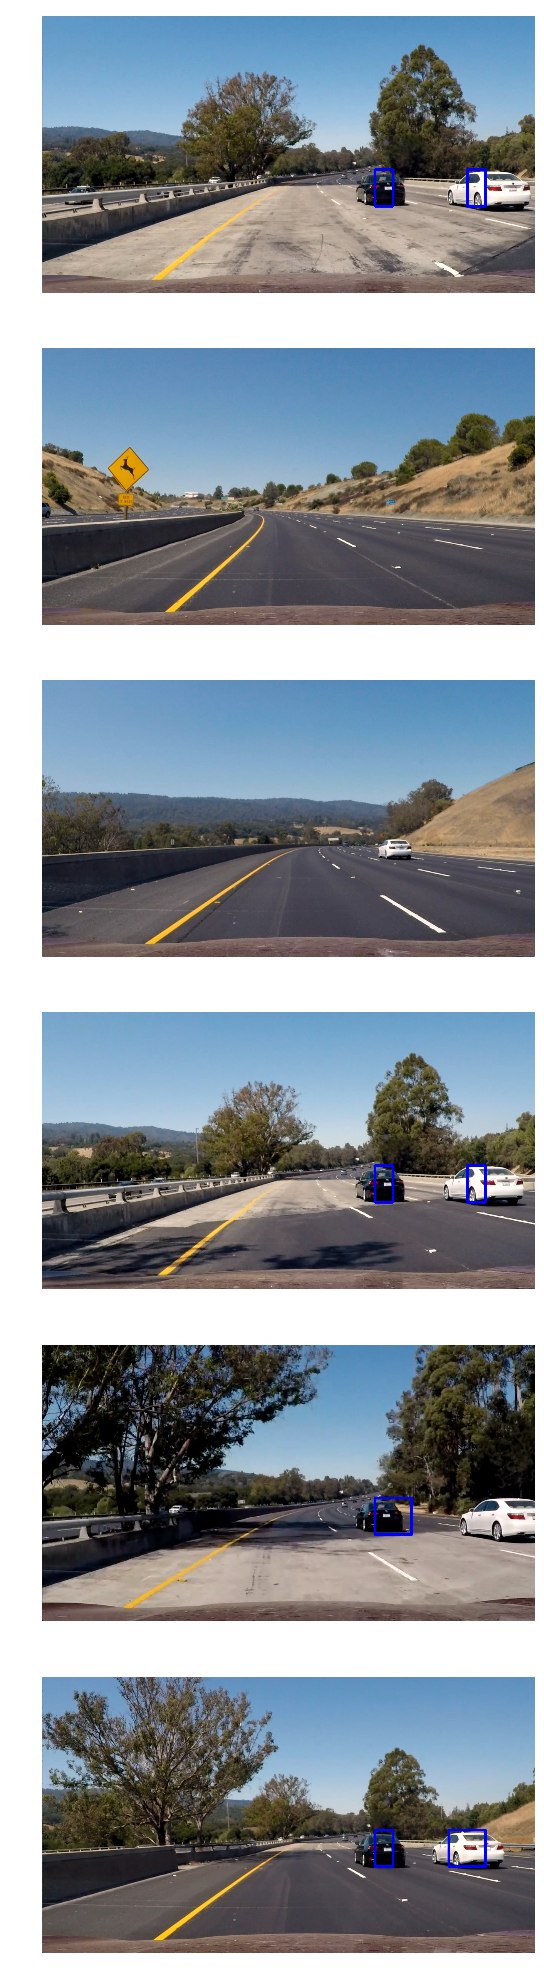

In [23]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(6, 1, figsize=(25,25))
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [31]:
counter = 0
output = 'project_video_out.mp4'
clip1 = VideoFileClip('project_video.mp4')
out_clip = clip1.fl_image(process_frame)
%time out_clip.write_videofile(output, audio=False)
print(counter)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:00<00:00, 10.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 2min 1s
0


In [32]:
#Play the video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))